# Finetune ResNet50


## resnet50_224zero


With 224x224 zero-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'resnet50_224zero'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_22252\3408896021.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.46it/s, Loss=0.5263552069664001, Elapsed=19.5969s, ETA=0.0000s] 


Epoch 1 completed in 93.6264s
Train Loss: 0.9618975001608017 - Train Accuracy: 59.17098211257095
Validation Loss: 0.8539006042480469 - Validation Accuracy: 65.09075559307725

Epoch 2/50


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.62it/s, Loss=0.09852654486894608, Elapsed=19.2111s, ETA=0.0000s]


Epoch 2 completed in 92.7855s
Train Loss: 0.7335382079802497 - Train Accuracy: 68.66194794328486
Validation Loss: 0.737941591044267 - Validation Accuracy: 69.64964119881807

Epoch 3/50


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.42it/s, Loss=0.06342550367116928, Elapsed=19.5640s, ETA=0.0000s]


Epoch 3 completed in 93.2687s
Train Loss: 0.615890277000521 - Train Accuracy: 73.63243707740666
Validation Loss: 0.7401770554979642 - Validation Accuracy: 72.75221612494724

EarlyStopping counter: 1/5
Epoch 4/50


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.28it/s, Loss=0.040520597249269485, Elapsed=19.5431s, ETA=0.0000s]


Epoch 4 completed in 93.2556s
Train Loss: 0.51171685781093 - Train Accuracy: 77.7956174668144
Validation Loss: 0.7347477935254574 - Validation Accuracy: 73.61756015196286

Epoch 5/50


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.24it/s, Loss=0.21860861778259277, Elapsed=19.5788s, ETA=0.0000s]


Epoch 5 completed in 93.2858s
Train Loss: 0.4210313718787507 - Train Accuracy: 81.58341059677528
Validation Loss: 0.9359033679962159 - Validation Accuracy: 70.5255382017729

EarlyStopping counter: 1/5
Epoch 6/50


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.20it/s, Loss=0.04618186876177788, Elapsed=19.7611s, ETA=0.0000s]


Epoch 6 completed in 93.3661s
Train Loss: 0.3223377236654993 - Train Accuracy: 85.18803283507836
Validation Loss: 0.8080638207495212 - Validation Accuracy: 73.12157028281976

EarlyStopping counter: 2/5
Epoch 7/50


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.46it/s, Loss=0.5741845965385437, Elapsed=19.3770s, ETA=0.0000s] 


Epoch 7 completed in 93.2786s
Train Loss: 0.25825521748276115 - Train Accuracy: 87.89489156735488
Validation Loss: 1.0655859462420145 - Validation Accuracy: 73.9447024060785

EarlyStopping counter: 3/5
Epoch 8/50


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.38it/s, Loss=0.003443895373493433, Elapsed=19.7503s, ETA=0.0000s]


Epoch 8 completed in 93.3332s
Train Loss: 0.20786600535186384 - Train Accuracy: 90.00927161303454
Validation Loss: 1.0627136544200282 - Validation Accuracy: 74.44069227522161

EarlyStopping counter: 4/5
Epoch 9/50


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.26it/s, Loss=0.32280731201171875, Elapsed=19.6045s, ETA=0.0000s]

Epoch 9 completed in 93.2767s
Train Loss: 0.15699181238436974 - Train Accuracy: 92.2548110626173
Validation Loss: 1.3028283103307088 - Validation Accuracy: 75.05276487969607

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


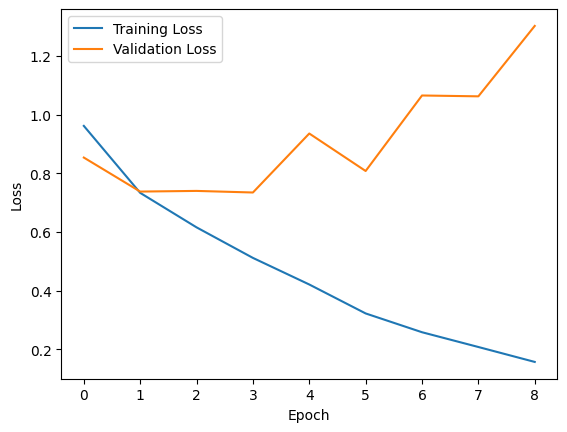

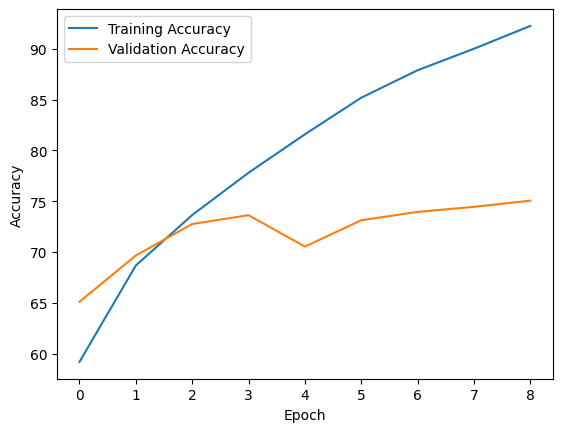

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.56it/s]

Test Accuracy: 0.7413
Test Precision: 0.7471
Test Recall: 0.7413
Test F1-score: 0.7413

              precision    recall  f1-score   support

       Anger       0.62      0.85      0.72       916
       Bored       0.84      0.87      0.86      1098
     Disgust       0.62      0.53      0.57       291
        Fear       0.56      0.50      0.53       308
       Happy       0.71      0.73      0.72      1914
     Neutral       0.72      0.71      0.72      2226
    Question       0.94      0.82      0.87      1139
         Sad       0.75      0.73      0.74       857
    Surprise       0.76      0.63      0.69       728

    accuracy                           0.74      9477
   macro avg       0.72      0.71      0.71      9477
weighted avg       0.75      0.74      0.74      9477



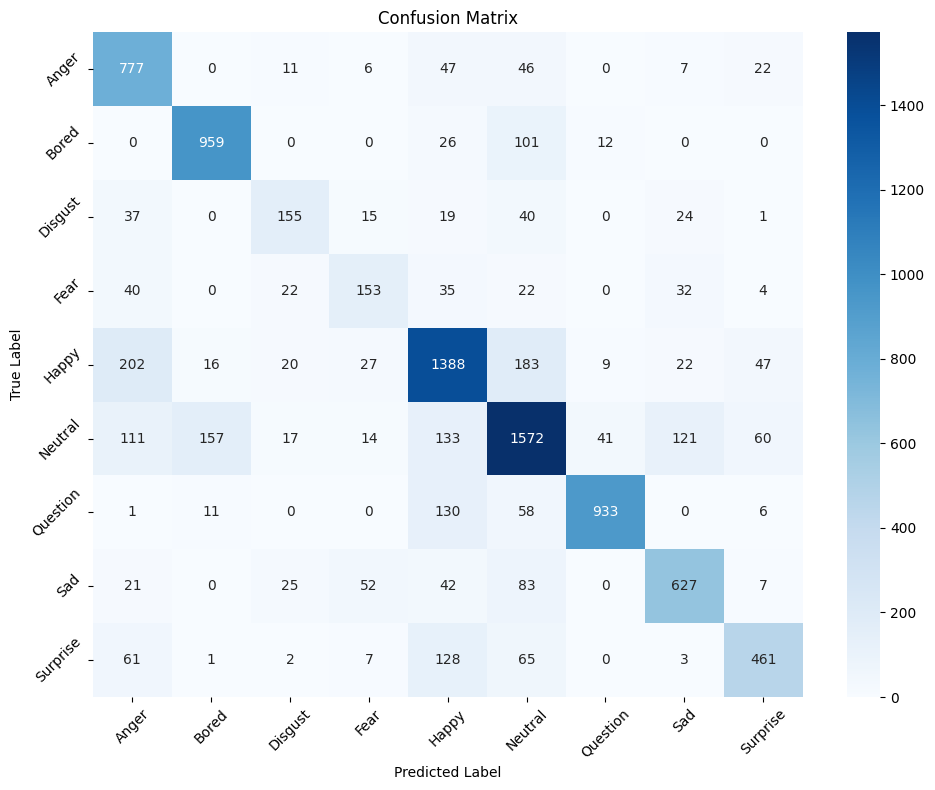

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)